In [1]:
pip install flask nbformat nbconvert



   --- ------------------------------------  1/13 [fastjsonschema]
   --- ------------------------------------  1/13 [fastjsonschema]
   ------ ---------------------------------  2/13 [tinycss2]
   --------- ------------------------------  3/13 [soupsieve]
   --------------- ------------------------  5/13 [mistune]
   --------------- ------------------------  5/13 [mistune]
   --------------- ------------------------  5/13 [mistune]
   --------------- ------------------------  5/13 [mistune]
   --------------- ------------------------  5/13 [mistune]
   ------------------ ---------------------  6/13 [jupyterlab-pygments]
   --------------------- ------------------  7/13 [defusedxml]
   ------------------------ ---------------  8/13 [bleach]
   ------------------------ ---------------  8/13 [bleach]
   ------------------------ ---------------  8/13 [bleach]
   ------------------------ ---------------  8/13 [bleach]
   ------------------------ ---------------  8/13 [bleach]
   ---------

In [3]:
# ======================================
# Section 1: Installation and Imports
# ======================================
!pip install split-folders tensorflow-model-optimization tensorflow-probability

print("--- Section 1: Importing Libraries & Mounting Drive ---")

# Keras compatibility fix
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_model_optimization as tfmot
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import json
#from google.colab import drive
#from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders

from sklearn.metrics import confusion_matrix, classification_report

# Mount Google Drive
#drive.mount('/content/drive', force_remount=True)
#print(f"Using TensorFlow Version: {tf.__version__}")


--- Section 1: Importing Libraries & Mounting Drive ---





In [4]:
print("\n--- Section 2: Configuring Paths and Preparing Data ---")
from pathlib import Path
import os
IMG_SIZE = (260, 260)
BATCH_SIZE = 32

RAW_DATA_DIR = Path('./data/datasets')
PROCESSED_DATA_DIR = Path('/content/dataset_processed')
SPLIT_DATA_DIR = Path('/content/ocularnet_data')
TRAIN_DIR = SPLIT_DATA_DIR / 'train'
VAL_DIR = SPLIT_DATA_DIR / 'val'
TEST_DIR = SPLIT_DATA_DIR / 'test'
CLASS_NAMES_PATH = "class_names.json"
MIXUP_ALPHA = 0.2

import os

# Step 0: Ensure raw data is in subfolders; if not, create one class folder `all` and move images there
if not any([f.is_dir() for f in RAW_DATA_DIR.iterdir()]):
    print(f"No class subdirectories detected in {RAW_DATA_DIR}. Creating default class folder 'all'.")
    default_class_dir = RAW_DATA_DIR / 'all'
    default_class_dir.mkdir(exist_ok=True)
    # Move all images in raw dir to 'all'
    for file in RAW_DATA_DIR.glob('*'):
        if file.is_file():
            target_path = default_class_dir / file.name
            if not target_path.exists():
                file.rename(target_path)

# Now proceed assuming RAW_DATA_DIR contains class subfolders
if SPLIT_DATA_DIR.exists() and all([(SPLIT_DATA_DIR / d).exists() for d in ['train', 'val', 'test']]):
    print(f"✅ Split data already present in {SPLIT_DATA_DIR}. Skipping preparation.")
else:
    print("Starting data preparation: Augmenting and splitting...")
    shutil.rmtree(PROCESSED_DATA_DIR, ignore_errors=True)
    shutil.rmtree(SPLIT_DATA_DIR, ignore_errors=True)

    try:
        class_dirs = [f for f in RAW_DATA_DIR.iterdir() if f.is_dir()]
        if not class_dirs:
            raise FileNotFoundError(f"No class subdirectories found in {RAW_DATA_DIR}. Check dataset organization.")

        image_counts = {folder.name: len(list(folder.glob('*'))) for folder in class_dirs}
        TARGET_COUNT = max(image_counts.values())
        print(f"Target image count per class: {TARGET_COUNT}")

        data_augmenter = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
        PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

        for class_name, count in image_counts.items():
            class_dir_raw = RAW_DATA_DIR / class_name
            class_dir_processed = PROCESSED_DATA_DIR / class_name
            class_dir_processed.mkdir(exist_ok=True)

            # Copy originals
            for fname in os.listdir(class_dir_raw):
                shutil.copy(class_dir_raw / fname, class_dir_processed / fname)

            # Augmentation if needed
            num_to_augment = TARGET_COUNT - count
            if num_to_augment > 0:
                print(f"Augmenting class '{class_name}' with {num_to_augment} images...")
                temp_aug_input_dir = Path('/content/temp_aug_source') / class_name
                os.makedirs(temp_aug_input_dir, exist_ok=True)
                for fname in os.listdir(class_dir_raw):
                    shutil.copy(class_dir_raw / fname, temp_aug_input_dir / fname)

                image_gen = data_augmenter.flow_from_directory(
                    directory=str(temp_aug_input_dir.parent),
                    classes=[class_name],
                    target_size=IMG_SIZE,
                    batch_size=1,
                    save_to_dir=str(class_dir_processed),
                    save_prefix='aug_',
                    save_format='jpg'
                )
                for _ in range(num_to_augment):
                    next(image_gen)
                shutil.rmtree(temp_aug_input_dir.parent)

        print("Splitting data into train/val/test folders...")
        splitfolders.ratio(PROCESSED_DATA_DIR, output=SPLIT_DATA_DIR, seed=42, ratio=(.8, .1, .1))
        print("✅ Data preparation and splitting complete.")

    except Exception as e:
        print("\n--- ERROR during data preparation ---")
        print(e)

# Load class names and count
try:
    CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
    NUM_CLASSES = len(CLASS_NAMES)
    print(f"Data loading complete. Found {NUM_CLASSES} classes: {CLASS_NAMES}")
    with open(CLASS_NAMES_PATH, "w") as f:
        json.dump(CLASS_NAMES, f)
except FileNotFoundError:
    print(f"Error: Training directory {TRAIN_DIR} not found. Cannot proceed.")

def preprocess_data_for_mixup(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

@tf.function
def mixup(images, labels, alpha=MIXUP_ALPHA):
    batch_size = tf.shape(images)[0]
    gamma_sample1 = tf.random.gamma(shape=[batch_size], alpha=alpha)
    gamma_sample2 = tf.random.gamma(shape=[batch_size], alpha=alpha)
    l = gamma_sample1 / (gamma_sample1 + gamma_sample2)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))
    shuffled_indices = tf.random.shuffle(tf.range(batch_size))
    mixed_images = x_l * images + (1.0 - x_l) * tf.gather(images, shuffled_indices)
    mixed_labels = y_l * labels + (1.0 - y_l) * tf.gather(labels, shuffled_indices)
    return mixed_images, mixed_labels

train_dataset_base = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
).map(preprocess_data_for_mixup, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
).map(preprocess_data_for_mixup, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
).map(preprocess_data_for_mixup, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset_with_mixup = train_dataset_base.map(mixup, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

print("✅ Data pipelines created successfully.")



--- Section 2: Configuring Paths and Preparing Data ---
Starting data preparation: Augmenting and splitting...
Target image count per class: 3387
Augmenting class 'cataract' with 2329 images...
Found 1058 images belonging to 1 classes.
Augmenting class 'conjunctivitis' with 3016 images...
Found 371 images belonging to 1 classes.
Augmenting class 'dme' with 381 images...
Found 3006 images belonging to 1 classes.
Augmenting class 'drusen' with 367 images...
Found 3020 images belonging to 1 classes.
Augmenting class 'glaucoma' with 373 images...
Found 3014 images belonging to 1 classes.
Augmenting class 'normal' with 315 images...
Found 3072 images belonging to 1 classes.
Splitting data into train/val/test folders...


Copying files: 23709 files [01:03, 373.57 files/s] 


✅ Data preparation and splitting complete.
Data loading complete. Found 7 classes: ['cataract', 'cnv', 'conjunctivitis', 'dme', 'drusen', 'glaucoma', 'normal']
Found 18963 files belonging to 7 classes.
Found 2366 files belonging to 7 classes.
Found 2380 files belonging to 7 classes.
✅ Data pipelines created successfully.


In [ ]:

# ======================================
# Section 3: Create and Train Teacher Model
# ======================================
print("\n--- Step 3: Training the Teacher Model (EfficientNetV2B2) ---")

base_model_teacher = tf.keras.applications.EfficientNetV2B2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet'
)
base_model_teacher.trainable = False

teacher_model = tf.keras.Sequential([
    base_model_teacher,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
], name="teacher_model")

teacher_train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
).map(lambda img, lbl: (tf.keras.applications.efficientnet_v2.preprocess_input(img), lbl)).prefetch(tf.data.AUTOTUNE)

teacher_val_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
).map(lambda img, lbl: (tf.keras.applications.efficientnet_v2.preprocess_input(img), lbl)).prefetch(tf.data.AUTOTUNE)

teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping_teacher = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

print("Starting initial teacher model training...")
teacher_model.fit(
    teacher_train_dataset,
    epochs=20,
    validation_data=teacher_val_dataset,
    callbacks=[early_stopping_teacher]
)
teacher_model.save("teacher_model_efficientnet.keras")
print("✅ Initial teacher model trained and saved.")

# --- Fine-tuning Teacher Model ---
print("Starting fine-tuning of teacher model...")

base_model_teacher.trainable = True
fine_tune_at = len(base_model_teacher.layers) - 30
for layer in base_model_teacher.layers[:fine_tune_at]:
    layer.trainable = False

teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

teacher_model.fit(
    teacher_train_dataset,
    epochs=10,
    validation_data=teacher_val_dataset,
    callbacks=[early_stopping_teacher]
)
teacher_model.save("teacher_model_efficientnet_finetuned.keras")
print("✅ Teacher model fine-tuned and saved.")


--- Step 3: Training the Teacher Model (EfficientNetV2B2) ---
Found 18963 files belonging to 7 classes.
Found 2366 files belonging to 7 classes.
Starting initial teacher model training...
Epoch 1/20
593/593 [==============================] - 1259s 2s/step - loss: 0.5535 - accuracy: 0.7837 - val_loss: 0.3772 - val_accuracy: 0.8622
Epoch 2/20
454/593 [=====================>........] - ETA: 3:58 - loss: 0.3948 - accuracy: 0.8466

In [ ]:
# ======================================
# Section 4: Knowledge Distillation with MixUp Augmentation
# ======================================
print("\n--- Step 4: Knowledge Distillation with MixUp ---")

def create_student_model_architecture():
    base_model_student = keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,), include_top=False, weights=None, alpha=0.35
    )
    base_model_student.trainable = True
    inputs_student = layers.Input(shape=IMG_SIZE + (3,))
    x_student = base_model_student(inputs_student)
    x_student = layers.GlobalAveragePooling2D()(x_student)
    x_student = layers.Dropout(0.3)(x_student)
    outputs_student = layers.Dense(NUM_CLASSES, activation="softmax")(x_student)
    return keras.Model(inputs_student, outputs_student, name="student_mobilenet")

student_model = create_student_model_architecture()

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.student = student
        self.teacher = teacher

    def call(self, inputs):
        return self.student(inputs, training=False)

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        for metric in self.metrics:
            metric.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": loss})
        return results

    def test_step(self, data):
        x, y = data
        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)
        for metric in self.metrics:
            metric.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": student_loss})
        return results

distiller = Distiller(student=student_model, teacher=teacher_model)

distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.5,        # Increase weight on distillation loss
    temperature=15    # Increase temperature for softer teacher outputs
)

early_stopping_student = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-6, verbose=1)

print("Starting student model distillation training...")
distiller.fit(
    train_dataset_with_mixup,
    epochs=150,  # Extended epochs
    validation_data=val_dataset,
    callbacks=[early_stopping_student, lr_scheduler]
)
print("✅ Student model distillation training complete.")
# Save the trained student model after distillation
student_model_path = "student_model_after_distillation.keras"
distiller.student.save(student_model_path)
print(f"✅ Student model saved to '{student_model_path}'.")




--- Step 4: Knowledge Distillation with MixUp ---
Starting student model distillation training...
Epoch 1/150
670/670 [==============================] - 180s 208ms/step - loss: 0.5609 - val_loss: 2.2916 - lr: 0.0010
Epoch 2/150
670/670 [==============================] - 137s 204ms/step - loss: 0.4086 - val_loss: 3.5471 - lr: 0.0010
Epoch 3/150
670/670 [==============================] - 141s 210ms/step - loss: 0.3433 - val_loss: 4.2996 - lr: 0.0010
Epoch 4/150
670/670 [==============================] - 141s 210ms/step - loss: 0.3048 - val_loss: 5.1722 - lr: 0.0010
Epoch 5/150
670/670 [==============================] - 137s 203ms/step - loss: 0.2848 - val_loss: 6.5658 - lr: 0.0010
Epoch 6/150
670/670 [==============================] - 141s 209ms/step - loss: 0.2689 - val_loss: 3.5300 - lr: 0.0010
Epoch 7/150
670/670 [==============================] - 138s 204ms/step - loss: 0.2521 - val_loss: 0.4813 - lr: 0.0010
Epoch 8/150
670/670 [==============================] - 138s 205ms/step - lo

In [8]:
# ======================================
# Section 5: Pruning and Fine-tuning Student Model
# ======================================
print("\n--- Step 5: Pruning Student Model ---")

print("Cloning model structure for pruning...")
student_model_for_pruning = keras.models.clone_model(student_model)
student_model_for_pruning.set_weights(student_model.get_weights())

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.60, begin_step=0, frequency=100)
}

print("Applying pruning wrapper...")
model_to_prune = tfmot.sparsity.keras.prune_low_magnitude(student_model_for_pruning, **pruning_params)

print("Fine-tuning pruned model...")
model_to_prune.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

model_to_prune.fit(
    train_dataset_base,
    epochs=20,  # Increased epochs for fine-tuning
    validation_data=val_dataset,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()]
)

final_pruned_model = tfmot.sparsity.keras.strip_pruning(model_to_prune)
final_pruned_model.save("student_model_pruned_final_v2.keras")
print("✅ Pruned and fine-tuned student model saved.")


--- Step 5: Pruning Student Model ---
Cloning model structure for pruning...
Applying pruning wrapper...
Fine-tuning pruned model...
Epoch 1/20
670/670 [==============================] - 187s 188ms/step - loss: 0.3935 - accuracy: 0.8765 - val_loss: 2.2596 - val_accuracy: 0.1695
Epoch 2/20
670/670 [==============================] - 126s 186ms/step - loss: 0.3273 - accuracy: 0.8947 - val_loss: 1.6081 - val_accuracy: 0.3240
Epoch 3/20
670/670 [==============================] - 125s 185ms/step - loss: 0.2831 - accuracy: 0.9067 - val_loss: 0.8057 - val_accuracy: 0.7071
Epoch 4/20
670/670 [==============================] - 121s 180ms/step - loss: 0.2523 - accuracy: 0.9156 - val_loss: 0.3448 - val_accuracy: 0.8997
Epoch 5/20
670/670 [==============================] - 125s 185ms/step - loss: 0.2298 - accuracy: 0.9247 - val_loss: 0.2310 - val_accuracy: 0.9282
Epoch 6/20
670/670 [==============================] - 125s 186ms/step - loss: 0.2164 - accuracy: 0.9268 - val_loss: 0.1988 - val_accurac

In [9]:
# ======================================
# Section 6: Final Evaluation and Comparison
# ======================================
print("\n--- Step 6: Evaluate Teacher and Student Models ---")

teacher_model_loaded = keras.models.load_model("teacher_model_efficientnet_finetuned.keras", compile=False)
student_model_loaded = keras.models.load_model("student_model_pruned_final_v2.keras", compile=False)

teacher_test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
).map(lambda img, lbl: (tf.keras.applications.efficientnet_v2.preprocess_input(img), lbl)).prefetch(tf.data.AUTOTUNE)

teacher_model_loaded.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
teacher_loss, teacher_acc = teacher_model_loaded.evaluate(teacher_test_dataset)

student_model_loaded.compile(loss='categorical_crossentropy', metrics=['accuracy'])
student_loss, student_acc = student_model_loaded.evaluate(test_dataset)

teacher_size = os.path.getsize("teacher_model_efficientnet_finetuned.keras") / (1024 * 1024)
student_size = os.path.getsize("student_model_pruned_final_v2.keras") / (1024 * 1024)

print("\n" + "="*30)
print("--- Model Performance Comparison ---")
print(f"Teacher Model (EfficientNetV2B2):")
print(f" Accuracy: {teacher_acc*100:.2f}%")
print(f" Size: {teacher_size:.2f} MB")
print("-" * 30)
print(f"Final Student Model (Pruned MobileNetV2):")
print(f" Accuracy: {student_acc*100:.2f}%")
print(f" Size: {student_size:.2f} MB")
print(f"\nCompression Ratio: {teacher_size / student_size:.1f}x smaller")
print("="*30)



--- Step 6: Evaluate Teacher and Student Models ---
Found 2687 files belonging to 7 classes.
84/84 [==============================] - 8s 79ms/step - loss: 0.1424 - accuracy: 0.9460

--- Model Performance Comparison ---
Teacher Model (EfficientNetV2B2):
 Accuracy: 94.79%
 Size: 45.06 MB
------------------------------
Final Student Model (Pruned MobileNetV2):
 Accuracy: 94.60%
 Size: 2.09 MB

Compression Ratio: 21.5x smaller



--- Step 7: Interactive Prediction ---
✅ Successfully loaded final model 'student_model_pruned_final_v2.keras'.

Please upload an image for classification (or click 'Cancel' to exit)...


Saving C0051906-Blepharitis_of_the_eye.jpg to C0051906-Blepharitis_of_the_eye.jpg

Uploaded 'C0051906-Blepharitis_of_the_eye.jpg'. Running prediction...


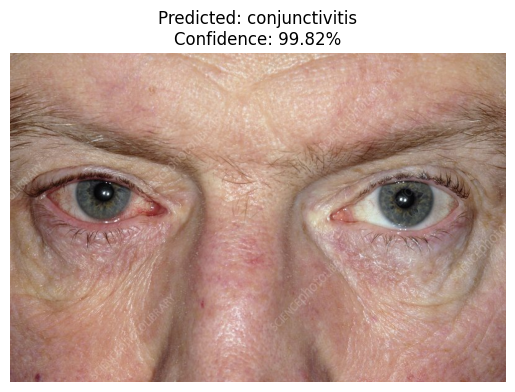


Please upload an image for classification (or click 'Cancel' to exit)...


Saving BEH-13.png to BEH-13.png

Uploaded 'BEH-13.png'. Running prediction...


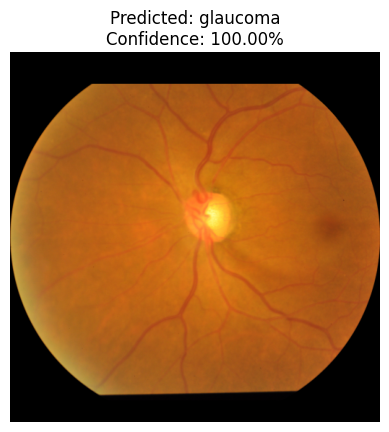


Please upload an image for classification (or click 'Cancel' to exit)...


KeyboardInterrupt: 

In [10]:
# ======================================
# Section 7: Interactive Prediction on Your Own Images
# ======================================
print("\n--- Step 7: Interactive Prediction ---")

MODEL_TO_LOAD = "student_model_pruned_final_v2.keras"
CONFIDENCE_THRESHOLD = 0.6  # Increased threshold for reliability

try:
    model = keras.models.load_model(MODEL_TO_LOAD)
    with open(CLASS_NAMES_PATH, 'r') as f:
        CLASS_NAMES = json.load(f)
    print(f"✅ Successfully loaded final model '{MODEL_TO_LOAD}'.")
    model_loaded = True
except Exception as e:
    print(f"❌ Error loading model or class names file: {e}")
    print("Please ensure previous steps completed successfully.")
    model_loaded = False

def predict_image(image_path, model, threshold):
    img_height = model.input_shape[1]
    img_width = model.input_shape[2]
    img_size = (img_height, img_width)

    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)

    img_array_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array_preprocessed = tf.expand_dims(img_array_preprocessed, 0)

    predictions = model.predict(img_array_preprocessed, verbose=0)
    score = predictions[0]

    confidence = np.max(score)
    predicted_class_index = np.argmax(score)

    if confidence >= threshold:
        predicted_class = CLASS_NAMES[predicted_class_index]
        return predicted_class, confidence * 100
    else:
        ood_class_name = "Unknown (Out-of-Distribution)"
        return ood_class_name, confidence * 100

if model_loaded:
    while True:
        print("\nPlease upload an image for classification (or click 'Cancel' to exit)...")
        try:
            uploaded = files.upload()
            if not uploaded:
                print("\nNo file uploaded. Exiting prediction loop.")
                break
            uploaded_filename = next(iter(uploaded))
            print(f"\nUploaded '{uploaded_filename}'. Running prediction...")

            predicted_class, confidence = predict_image(
                uploaded_filename, model, CONFIDENCE_THRESHOLD
            )

            plt.imshow(plt.imread(uploaded_filename))
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"\nAn error occurred: {e}")
            break
